In [5]:
cd Chapter07

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'Chapter07'
C:\Users\revol\Chapter07


In [12]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.pardir)
from common.util import im2col
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from common.trainer import Trainer



x1 : 채널이 3개고, 채널 1개당 7 * 7데이터임, 필터는 5 * 5, 그래서 계산과정 9번이라 생각하면 됌.<br>
필터적용영역 1개를 가로로 쭉 펼치는 거니까 9개가 나옴.(9 * 25) 여기에 채널 3개를 옆에다가 붙이면 9 * 75

In [14]:
import numpy as np
import pandas as pd

import os
import sys
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride =1 , pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


In [30]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [31]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col, axis = 1)
        out = np.max(col, axis = 1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        return out
    

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [35]:

class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    전체 구현은 simple_convnet.py 참고
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        # 초기화 인수로 주어진 하이퍼파라미터를 딕셔너리에서 꺼내고 출력 크기를 계산한다.
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        # 1층의 합성곱 계층과 2, 3층의 완전연결 계층의 가중치와 편향 생성
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층을 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """추론을 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

train loss:2.2992482722759324
=== epoch:1, train acc:0.31, test acc:0.295 ===
train loss:2.2968702543211394
train loss:2.291402420040946
train loss:2.2838029526280508
train loss:2.2781397583643983
train loss:2.2630675281934867
train loss:2.25078586847934
train loss:2.2403130974254366
train loss:2.205330139988918
train loss:2.189071275841958
train loss:2.145585362575498
train loss:2.106172872848768
train loss:2.09844306320091
train loss:2.002590398062306
train loss:1.9514590372802243
train loss:1.8997964942476682
train loss:1.8225829036519174
train loss:1.7005209812132218
train loss:1.65093084842943
train loss:1.5502548828858411
train loss:1.464838636353573
train loss:1.4657267991640168
train loss:1.207798629138668
train loss:1.2323189595699189
train loss:1.2188873246798702
train loss:1.0270284974842046
train loss:1.0501332663277112
train loss:0.9564333590846411
train loss:0.7781037529959945
train loss:0.887559319658332
train loss:0.8740857448757966
train loss:0.7556315432499656
train l

train loss:0.08154920364987632
train loss:0.09690423537463957
train loss:0.12778860370207265
train loss:0.11230334567426128
train loss:0.12471722731254152
train loss:0.10914239004510959
train loss:0.2499287346804386
train loss:0.19800151702549126
train loss:0.24758273979618464
train loss:0.08693488583478688
train loss:0.16503392178095935
train loss:0.13787379094526683
train loss:0.07493040021503478
train loss:0.09988494575757216
train loss:0.11180287314866916
train loss:0.18770857168198343
train loss:0.09602731295683195
train loss:0.10173088940832384
train loss:0.10394455573557476
train loss:0.14886146712392498
train loss:0.133750648815539
train loss:0.21896865753962885
train loss:0.10382707310123714
train loss:0.30054565097271096
train loss:0.1305694407852433
train loss:0.21345026159538044
train loss:0.13505561353076068
train loss:0.1489339962021632
train loss:0.07567406286798707
train loss:0.3520993718745497
train loss:0.1285243945065785
train loss:0.07999348402850978
train loss:0.11

train loss:0.0824368550963062
train loss:0.03867704344154018
train loss:0.06229681355851528
train loss:0.040887065378158255
train loss:0.06435039345671985
train loss:0.04368264589009697
train loss:0.04159761427555484
train loss:0.03896159654405396
train loss:0.09868257307470324
train loss:0.044923730252715205
train loss:0.07069209255753335
train loss:0.028159057991141774
train loss:0.02594388134247546
train loss:0.07358267906692278
train loss:0.04165701093004936
train loss:0.03868534162535969
train loss:0.043764760599973834
train loss:0.09894196065036098
train loss:0.09954254369790468
train loss:0.04979902109243409
train loss:0.030312175464897995
train loss:0.14417032479155079
train loss:0.1360570142027201
train loss:0.09593818065512667
train loss:0.11281343094610718
train loss:0.031249452256527963
train loss:0.06396428870833457
train loss:0.08177048844040932
train loss:0.030311371919063714
train loss:0.07113596110411348
train loss:0.028956148225123636
train loss:0.039418097112110875
=

train loss:0.05401895587373792
train loss:0.02002030774863941
train loss:0.02751692112622898
train loss:0.016642624318960634
train loss:0.06361394709754457
train loss:0.027780478083959184
train loss:0.014138351480087259
train loss:0.02896601307003199
train loss:0.03348720527082642
train loss:0.02824369598745461
train loss:0.030031603187786235
train loss:0.055996915361082644
train loss:0.021312862014384083
train loss:0.016839054958072645
train loss:0.022891518321738472
train loss:0.0156921319297635
train loss:0.023552102225698462
train loss:0.022018693488795527
train loss:0.02054252770918513
train loss:0.020700329130526284
train loss:0.11174170650254556
train loss:0.055104489337195285
train loss:0.049434759350723674
train loss:0.014260344076934557
train loss:0.019347290334178906
train loss:0.03840408656337234
train loss:0.03061736982330254
=== epoch:17, train acc:0.988, test acc:0.964 ===
train loss:0.04112388869686729
train loss:0.11919232577051371
train loss:0.022003391890480548
train

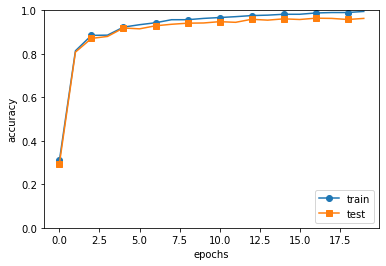

In [36]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = False)

x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim = (1, 28, 28),
                      conv_param = {'filter_num' : 30, 'filter_size' : 5,
                                   'pad' : 0, 'stride' : 1},
                      hidden_size = 100, output_size = 10, weight_init_std = 0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                 epochs = max_epochs, mini_batch_size = 100,
                 optimizer = 'Adam', optimizer_param = {'lr' : 0.001},
                 evaluate_sample_num_per_epoch = 1000)

trainer.train()

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()